# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В нашем распоряжении есть набор данных, содержащий примеры комментариев, размеченных по степени токсичности. Задача - добиться качественного определения токсичности комментария с F1 не менее 0.75.
Для решения задач планируется использование нейросети-трасформера BERT.

In [1]:
!pip install wordcloud==1.8.2.2
!pip install --upgrade Pillow==9.5.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [23]:
import numpy as np
import pandas as pd
import os
import tqdm 
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
 
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler,SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, f1_score, accuracy_score, precision_score, precision_recall_curve
from tqdm import trange 

import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, ImageColorGenerator

%matplotlib inline

## Загрузка данных, знакомство и подготовка

In [42]:

#Это путь для загурзки в среде Практикума
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'E:\\Data\\_Projects\\datasets\\toxic_comments.csv'


if os.path.exists(pth1):
    data = pd.read_csv(pth1,index_col=0)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2,index_col=0)
else:
    print('Something is wrong')


In [43]:
display(data.sample(10))

,text,toxic
154993,I'm afraid I have no idea what the sentence is...,0
151287,"Read the source, idiot.",1
87109,"""\nGeez. And from looking at his user page he ...",0
87050,"""==In response to your feedback==\n\nHi, and w...",0
120315,"""\nI dont believe he'll be able to do so seein...",0
84971,""" for what is considered a'innapropiate"""", and...",0
8799,I notice that you rated \n\nMerchants' Nationa...,0
149513,Reader feedback: i would like to know ( and i....,0
110804,October 2008 \n Please stop. If you continue t...,0
113155,"I believe the content of the sections Theoria,...",0


In [44]:
data.shape

(159292, 2)

Визуализируем распределение наших комментариев по типам.

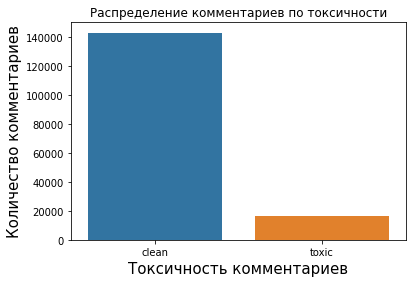

In [45]:

chart = sns.barplot(data=data, x=['clean','toxic'], y=data['toxic'].value_counts())
chart.set_title('Распределение комментариев по токсичности')
chart.set_xlabel('Токсичность комментариев', fontdict={'size': 15})
chart.set_ylabel('Количество комментариев', fontdict={'size': 15})
plt.show()


Мы наблюдаем серьёзный дисбаланс классов, что может сказаться на предсказательной силе нашей модели.

In [46]:
data.duplicated(subset='text', keep='first').sum()

0

In [47]:
data.isna().sum()

text     0
toxic    0
dtype: int64

Зато в нашем датасете нет пропусков и явных дубликатов.

Наши данные готовы к работе. Так как мы планируем использовать BERT, внуть которого вшито много предобработки, больше никаких манипуляций с данными делать небудем.


## Разделение набора данных

In [48]:
# Разделим данные на обучающий, тестовый набор
train_data, test_data = train_test_split(
    data, test_size=0.25, random_state=42)

In [59]:

# Отделим токсичные комментарии от нормальных
train_toxic = train_data[train_data['toxic']==1]
train_clean = train_data[train_data['toxic'] == 0]

print(train_toxic.shape)
print(train_clean.shape)

(12169, 2)
(107300, 2)


In [60]:
def create_cloud_of_words(data, ax, name):
    text = " ".join(comment for comment in data)
    wordcloud = WordCloud(background_color="white",random_state=1).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(name)
    ax.axis("off")
    return ax

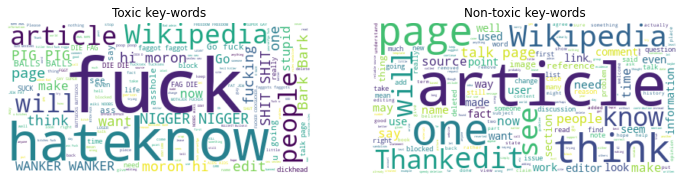

In [61]:
#Посмотрим на графике какие слова доминируют в токсичных и нетоксичных комментариях
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0]=create_cloud_of_words(train_toxic.text, axes[0], "Toxic key-words")
axes[1]=create_cloud_of_words(train_clean.text, axes[1], "Non-toxic key-words")

plt.show()

Определённо характерный набор бранных слов бросается вглаза, и наверняка его заметит (во всех смыслах) и нейросеть при обучении.

In [66]:
# Выберем из нетоксичных комментариев столько же случайных, сколько у нас есть токсичных
train_clean_sampled = train_clean.sample(n=12169, random_state=42)
 
# Объединим их с токсичными
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)
 
# Всё перемешаем и это будет наш базовый набор данных для дальнейшей работы
dataframe = dataframe.sample(frac=1, random_state=42)

In [67]:
#Подготовим обучающий и тестовый набор текстов и меток
train_texts= dataframe['text']
train_labels=dataframe['toxic']
test_texts=test_data['text']
test_labels=test_data['toxic']

## Перевод текста в векторную форму

In [68]:
# Инициализируем встроенный токенизатор от Берта
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [69]:
# Проведёт токенизацию комментариев, и преобразуем их в вектора одинаковой длины, заполняя недостающие слова спец-симовлами

encoder_train = tokenizer.batch_encode_plus(train_texts.values,
                                           add_special_tokens = True,
                                            return_attention_mask = True,
                                           pad_to_max_length = True,
                                            truncation=True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(test_texts.values,
                                           add_special_tokens = True,
                                           return_attention_mask = True,
                                           pad_to_max_length = True,
                                           truncation=True,
                                           max_length = 256,
                                           return_tensors = 'pt')
#Переводим наши вектора в формат пригодный для обучения нейросети
input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(train_labels.values)
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
#То же самое для тестового набора данных
input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(test_labels.values)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

In [70]:
len(data_train),len(data_test)

(24338, 39823)

Вывод: Данных получилось достаточно много для нормального обучения, проблемму дисбаланса класса на обучающей выборке мы решили, они переведены в нужный формат, можем начинать обучение.

## Построение модели BERT

In [81]:
#Инициализируем предобученный трансформер, оптимизированный для токсичных комментов. Кто-то сделал за нас всё интересную работу.
model = torch.hub.load('unitaryai/detoxify','toxic_bert')

Downloading: "https://github.com/unitaryai/detoxify/zipball/master" to C:\Users\Admin/.cache\torch\hub\master.zip
Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt" to C:\Users\Admin/.cache\torch\hub\checkpoints\toxic_original-c1212f89.ckpt
100%|███████████████████████████████████████████████████████████████████████████████| 418M/418M [00:39<00:00, 11.2MB/s]


In [82]:
#Сделаем загрузчики, чтобы можно было скармливать нейросети данные маельникими партиями, что снижает риск переобучения
dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16
    
)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32
    
)

Оптимизатор AdamW - это вариант алгоритма Adam, который был предложен для ускорения обучения нейронных сетей. Он был разработан с целью улучшения сходимости и уменьшения колебаний при обучении глубоких нейронных сетей с использованием стохастического градиентного спуска.

In [83]:
#Настроим оптимизатор
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)
#Инициализируем остальные параметры для настройки обучения нейросети
epochs  = 3
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs 
)

In [84]:
#Создадим функцию оценки целевой метрики F1, на основании предсказаний нашей модели
def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat)

In [85]:
#Создадим функцию оценки точности предсказаний внутри каждого класса
def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class:{label_dict_reverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [86]:
dict_label = {'normal': 0,
             'toxic': 1}

In [87]:
#Зафиксируем генератор случайных чисел для воспроизводимости
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [88]:
#Попробуем добавить мощности видокарты для ускорения вычислений
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

Loading:cuda


In [89]:
#Напишем процедуру оценки результатов работы нейросети, чтобы учитывать её при обучении на каждой эпохе
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        
    loss_val_avg = loss_val_total/len(dataloader_val)  
    
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,predictions,true_vals

In [90]:
history=pd.DataFrame(columns=['Epoch','Training Loss','Val Loss','F1'])
#Проводим собственно обучение нейросети
for epoch in tqdm(range(1,epochs+1)):
    #Включаем режим обучения
    model.train()
    #Обнуляем функцию потерь для каждой эпохи
    loss_train_total=0
    #Настраиваем индикатор програсса, чтобы нескучно было наблюдать за процессов
    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)
    
    
    for batch in progress_bar:
        model.zero_grad()
        #Будем брать данные мелкими партиями из загрузчика
        batch = tuple(b.to(device) for b in batch)
        #Распакуем партию на набор векторов подаваемых на вход нейросети
        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]
            
        }
        #Получаем предсказание нейросети
        outputs = model(**inputs)
        #Найдём значение функции потерь
        loss = outputs[0]
        #Проведём накопление функции потерь
        loss_train_total +=loss.item()
        loss.backward()
        #ограничиваем норму градиентов, это помогает предотвратить взрывное распространение градиентов и стабилизировать процесс обучения
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
    #Выводим результаты по конкретной эпохе
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score}')
    history=history.append(pd.Series([epoch, loss_train_avg,val_loss,test_score], index=history.columns), ignore_index=True)    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/1522 [00:00<?, ?it/s]


Epoch 1
Training Loss: 0.1691066183856338


  0%|          | 0/1245 [00:00<?, ?it/s]

Val Loss:0.08776766027914862
 Test Score:0.8843840498997549


Epoch: 2:   0%|          | 0/1522 [00:00<?, ?it/s]


Epoch 2
Training Loss: 0.041390672798116895


  0%|          | 0/1245 [00:00<?, ?it/s]

Val Loss:0.08248366507838095
 Test Score:0.9171116786626421


Epoch: 3:   0%|          | 0/1522 [00:00<?, ?it/s]


Epoch 3
Training Loss: 0.021702389889180267


  0%|          | 0/1245 [00:00<?, ?it/s]

Val Loss:0.09154992872939341
 Test Score:0.918704868390403


In [91]:
history

,Epoch,Training Loss,Val Loss,F1
0,1.0,0.169107,0.087768,0.884384
1,2.0,0.041391,0.082484,0.917112
2,3.0,0.021702,0.091550,0.918705


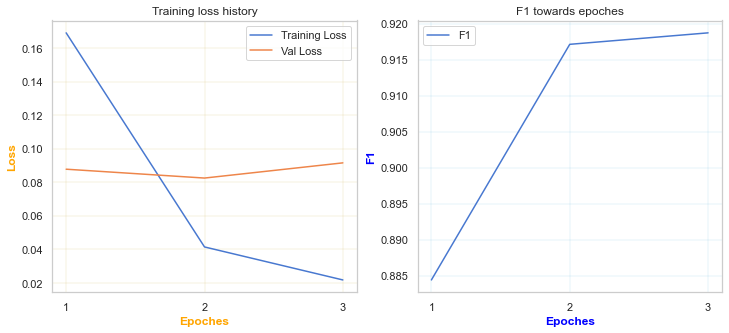

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.Epoch, history['Training Loss'],label='Training Loss')
axes[0].plot(history.Epoch, history['Val Loss'],label='Val Loss')
axes[0].legend()
axes[0].set_title('Training loss history')
axes[0].set_xlabel('Epoches',  fontweight='bold', color = 'orange', fontsize='12', horizontalalignment='center')
axes[0].set_ylabel('Loss',  fontweight='bold', color = 'orange', fontsize='12', horizontalalignment='center')

axes[0].grid(color='y', linestyle='-', linewidth=0.2,which='major')
axes[0].xaxis.set_ticks([1,2,3])
#plt.ylabel('Loss', fontweight='bold', color = 'orange', fontsize='17', horizontalalignment='center')
axes[1].plot(history.Epoch, history.F1,label='F1')
axes[1].set_title('F1 towards epoches')
axes[1].set_xlabel('Epoches',  fontweight='bold', color = 'blue', fontsize='12', horizontalalignment='center')
axes[1].set_ylabel('F1',  fontweight='bold', color = 'blue', fontsize='12', horizontalalignment='center')
axes[1].legend()
axes[1].grid(color='c', linestyle='-', linewidth=0.2,which='major')
axes[1].xaxis.set_ticks([1,2,3])
plt.show()

Мы видем, что модель обучилась достаточно неплохо. По крайней мере F1 продолжил рост на тестовой выборке, и превозошёл целевой уровень в 0,75.

In [93]:
#Оценим результаты обучения модели на тестовом наборе данных
_,predictions,true_vals = evaluate(dataloader_test)

  0%|          | 0/1245 [00:00<?, ?it/s]

In [94]:
#Взглянем на точность онесения занчений к каждому классу
accuracy_per_class(predictions,true_vals)

Class:normal
Accuracy:35181/35806

Class:toxic
Accuracy:3944/4017



Более наглядно это сделает ConfusionMatrix, его покажем далее.

Теперь пришла пора посмотреть, несколько хорошо с данной задачей классификации справляются незатейливые модели класса dummy.
Оценим их F1 и посмотрим на матрицы ошибок

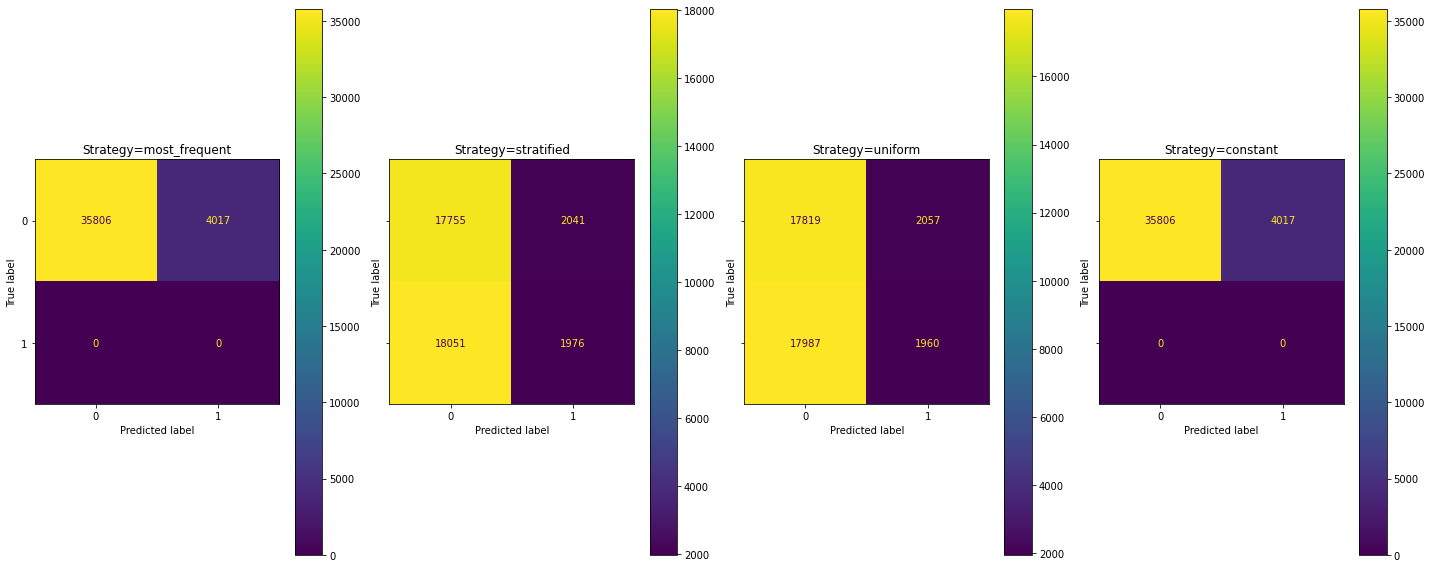

In [95]:
strategies = ['most_frequent', 'stratified', 'uniform', 'constant'] 
eva=pd.DataFrame(columns=['Model','F1'])
test_scores = [] 
fold=1
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True,figsize=(20, 8))
for s in strategies: 
    if s =='constant': 
        dclf = DummyClassifier(strategy = s, random_state = 0, constant =0) 
    else: 
        dclf = DummyClassifier(strategy = s, random_state = 0) 
    dclf.fit(input_ids_train, train_labels.values) 
    predicted_labels=dclf.predict(input_ids_test)
    f1_ = f1_score(test_labels, predicted_labels)
    test_scores.append(f1_)  
    eva=eva.append(pd.Series(["dymmy_"+s, f1_], index=eva.columns), ignore_index=True)
    axs[fold-1].set(xlabel='Predicted Label ', ylabel='True Label',title='Strategy={}'.format(s))
    cm = confusion_matrix(predicted_labels, test_labels)
    ConfusionMatrixDisplay(cm).plot(ax=axs[fold-1])

    fold=fold+1
eva=eva.append(pd.Series(["BERT", f1_score_func(predictions,true_vals)], index=eva.columns), ignore_index=True)    

Вывод: Dummy алгоритмы тут крайне плохо угадывают реально токсчиные комментарии. Будем надеяться что BERT сможет справиться лучше.

In [96]:
eva.style.highlight_max(color='lightgreen', subset=['F1']).highlight_min(color='red', subset=['F1'])

,Model,F1
0,dymmy_most_frequent,0.000000
1,dymmy_stratified,0.164365
2,dymmy_uniform,0.163579
3,dymmy_constant,0.000000
4,BERT,0.918705


1) Мы видим, что dummy-алгоритмы пасуют перед задачей, так что применение нейросети становится оправданным.
2) Всё-таки метрика F1 у нашей нейросети значительно выше, чем у самых успешных dummy, занчит считали мы это не зря. И что ещё лучше, она больше чем целевое значение в 0,75.

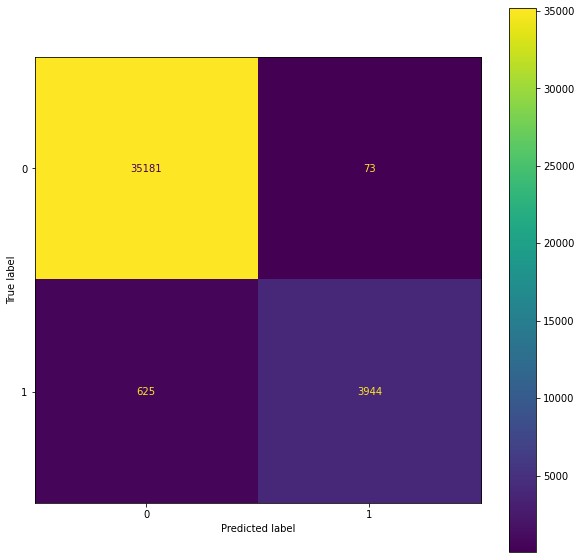

In [97]:
#Посмторим на матрицу ошибок предсказаний нашей неросети
predz = np.argmax(predictions,axis=1).flatten()
cm = confusion_matrix(predz, true_vals)
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(cm).plot(ax=ax)

**Вывод:**

1) Модель почти не делает ошибок в нетоксчиных комментариях. Лишь единицы будут незаслуженно отправляться на модерацию. 
2) Модель угадала 86% токсичных комментарием, это конечно очень хорошо. Учитывая, что их вообще достаточно мало от общей массы, после модерации, рядовому пользователю будет достаточно трудно наткнуться на них.

**Общий вывод по проекту**
1. Нам достался вполне пригодный набор данных, не требующий предобработки.
2. В наборе данных наблюдался сильный дисбаланс классов, что наложило определённые требования на подготовку обучающего набора данных и сказалось на применимости метрики F1. Она была выше целевого значения даже у половины dummy-алгоритмов.
3. Была проведена токенизация и векторизация текста, для получения набора признаков, пригодных для дообучения предобученной нейросети BERT.
4. В результате обучения удалось выйти не только на целевое значение метрики F1>75, но и правильно классифицировать более 60% токсичных комментариев.
5. В качестве дальнейших рекомендаций можно празработать фильтр "плохих слов", по аналогии с YouTube Blacklist Words.


# Послесловие - посмотрим как именно BERT вызявляет токсичные комментарии

In [98]:
!pip install transformers-interpret

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [99]:
from transformers_interpret import SequenceClassificationExplainer

In [100]:
cls_explainer = SequenceClassificationExplainer(model, tokenizer)

In [101]:
# Extract five random sentences based on a pre-selection
random_sentences = data[data['toxic']==1].sample(n=5,random_state=1234)['text'].reset_index(drop=True)

# Print each sentence in its full length
for sentence in range(len(random_sentences)): 
  print(random_sentences[sentence])

And the M-theory (simplified) version has the same thing as the String Theory article. Should I just assume that whoever wrote this article was being dumb?
I am sick of all these problems from incompetent Admins - this time I am going to have some action taken against them. This was ridiculous block with no justification or reason, what's more it was against an Arbcom ruling and the blocking Admin knew it. Now de-sysop her!
YOU BASTARD!

YOU STUPID BITCH! JUST BECAUSE YOU'RE A MOD YOU JUST CANT ACT LIKE YOURE THE BOOS AROUND HERE! YOU DONT OWN WIKIPEDIA!!!!

I HAVE CLEAN EDITS AND I DONT EVEN VANDALISE ANYTHING AND I GAVE THOSE RESOURCES THAT YOU SAID!  ITS ON THE SHOW'S WEBSITE! I SAID IT SO MANY TIMES! YOU DONT EVEN WATCH THAT SHOW! WHAT DO YOU CARE?!?!!!

IM GONNA REPORT YOU YOU CORRUPT MOD!!!
hey 

your a gay nigger mother fucking cunt
hello you are all silly WUBBA WUBBA MITT ROMNEY IS A DICTATOR


In [102]:
word_attributions = cls_explainer(random_sentences[1])
cls_explainer.predicted_class_name

'LABEL_1'

In [103]:
cls_explainer.visualize()

In [104]:
wa=pd.DataFrame(word_attributions)
wa=wa.sort_values(by=[1], ascending=False)

[Text(0.5, 1.0, 'feature importance chart')]

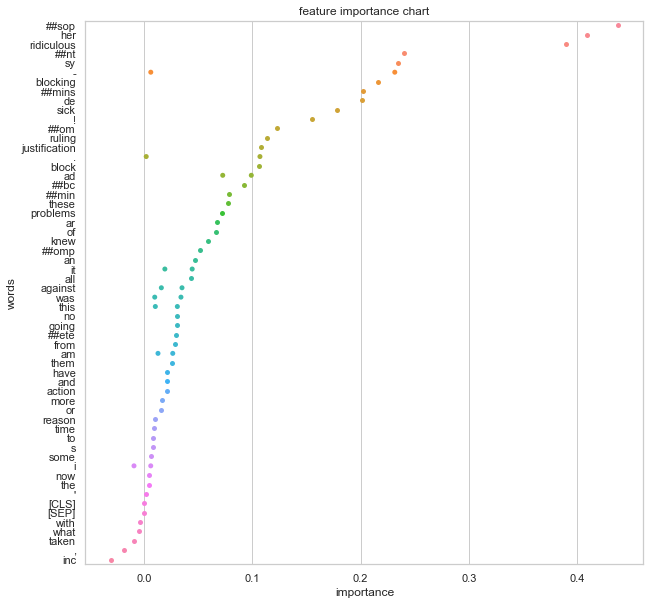

In [105]:
sns.set_theme(style="whitegrid", palette="muted")
fig, ax = plt.subplots(figsize=(10,10))
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=wa, x=1, y=0)
ax.set(ylabel="words")
ax.set(xlabel="importance")
ax.set(title="feature importance chart")